# **Product Recognition of Books**

## Image Processing and Computer Vision - Assignment Module \#1


Contacts:

- Prof. Giuseppe Lisanti -> giuseppe.lisanti@unibo.it
- Prof. Samuele Salti -> samuele.salti@unibo.it
- Alex Costanzino -> alex.costanzino@unibo.it
- Francesco Ballerini -> francesco.ballerini4@unibo.it

Computer vision-based object detection techniques can be applied in library or bookstore settings to build a system that identifies books on shelves.

Such a system could assist in:
* Helping visually impaired users locate books by title/author;
* Automating inventory management (e.g., detecting misplaced or out-of-stock books);
* Enabling faster book retrieval by recognizing spine text or cover designs.

## Task
Develop a computer vision system that, given a reference image for each book, is able to identify such book from one picture of a shelf.

<figure>
<a href="https://ibb.co/pvLVjbM5"><img src="https://i.ibb.co/svVx9bNz/example.png" alt="example" border="0"></a>
</figure>

For each type of product displayed on the shelf, the system should compute a bounding box aligned with the book spine or cover and report:
1. Number of instances;
1. Dimension of each instance (area in pixel of the bounding box that encloses each one of them);
1. Position in the image reference system of each instance (four corners of the bounding box that enclose them);
1. Overlay of the bounding boxes on the scene images.

<font color="red"><b>Each step of this assignment must be solved using traditional computer vision techniques.</b></font>

#### Example of expected output
```
Book 0 - 2 instance(s) found:
  Instance 1 {top_left: (100,200), top_right: (110, 220), bottom_left: (10, 202), bottom_right: (10, 208), area: 230px}
  Instance 2 {top_left: (90,310), top_right: (95, 340), bottom_left: (24, 205), bottom_right: (23, 234), area: 205px}
Book 1 – 1 instance(s) found:
.
.
.
```

## Data
Two folders of images are provided:
* **Models**: contains one reference image for each product that the system should be able to identify;
* **Scenes**: contains different shelve pictures to test the developed algorithm in different scenarios.

## Evaluation criteria
1. **Clarity and conciseness**. Present your work in a readable way: format your code and comment every important step;

2. **Procedural correctness**. There are several ways to solve the assignment. Design your own sound approach and justify every decision you make;

3. **Correctness of results**. Try to solve as many instances as possible. You should be able to solve all the instances of the assignment, however, a thoroughly justified and sound procedure with a lower number of solved instances will be valued **more** than a poorly designed and justified approach that solves more or all instances.

In [ ]:
"""
from google.colab import drive
drive.mount('/content/drive')

!cp -r /content/drive/MyDrive/Colab_Notebooks/IPCV/dataset.zip ./
!unzip dataset.zip
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Archive:  dataset.zip
replace dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Define the URL to the dataset.zip file in the GitHub repository
dataset_url = 'https://github.com/andreeado/ipcv/blob/main/dataset.zip' # Replace with the actual URL

# Download the dataset using wget
!wget {dataset_url}

# Unzip the dataset
!unzip dataset.zip -o # Use -o to overwrite existing files if necessary

In [ ]:
# Demo: run improved multi-instance detector for one model/scene
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Prepare paths
scenes_paths = [f"dataset/scenes/scene_{i}.jpg" for i in range(29)]
model_paths = [f"dataset/models/model_{i}.png" for i in range(22)]

# Load images (scenes color, scenes grayscale, models grayscale)
scenes = [cv2.imread(path) for path in scenes_paths]
scenes_grayscale = [cv2.cvtColor(scene, cv2.COLOR_BGR2GRAY) for scene in scenes]
models = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in model_paths]

# Precompute SIFT keypoints and descriptors for all models and scenes for performance
sift = cv2.SIFT_create()
models_kp_des = {}  # dict: idx -> {img, kp, des}
for i, img in enumerate(models):
    if img is None:
        models_kp_des[i] = {'img': None, 'kp': None, 'des': None}
        continue
    kp, des = sift.detectAndCompute(img, None)
    models_kp_des[i] = {'img': img, 'kp': kp, 'des': des}

scenes_kp_des = {}  # dict: idx -> {img_color, img_gray, kp, des}
for i, (img_color, img_gray) in enumerate(zip(scenes, scenes_grayscale)):
    if img_gray is None or img_color is None:
        scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': None, 'des': None}
        continue
    kp_s, des_s = sift.detectAndCompute(img_gray, None)
    scenes_kp_des[i] = {'img_color': img_color, 'img_gray': img_gray, 'kp': kp_s, 'des': des_s}

print('Precomputed SIFT keypoints/descriptors for', len(models_kp_des), 'models and', len(scenes_kp_des), 'scenes')

Precomputed SIFT keypoints/descriptors for 22 models and 29 scenes


In [ ]:
# Improved multi-instance detection utilities (adapted from BL implementation)

def compute_rectangularity(bounds):
    x, y, w, h = cv2.boundingRect(bounds)
    bounds_area = cv2.contourArea(bounds)
    rect_area = w * h if w * h > 0 else 1
    return bounds_area / rect_area

lowes_ratio = 0.72
min_match_percent = 0.01
ransac_error = 3

sift_scene = cv2.SIFT_create(sigma=0.4)

def instance_in_scene(processed_model, img_scene: np.array, debug=False):
    """Given a processed model (dict with keys 'image','keypoints','descriptors') and a grayscale scene image,
    this computes one instance (if any), masks it out in the provided scene image and returns the polygon (4 corners) in scene coords."""
    # SIFT feature extraction on the scene
    kp_scene, des_scene = sift_scene.detectAndCompute(img_scene, None)

    # Feature matching
    matcher = cv2.BFMatcher()
    if processed_model.get('descriptors') is None or des_scene is None:
        return None
    matches = matcher.knnMatch(processed_model['descriptors'], des_scene, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m_n in matches:
        if len(m_n) != 2:
            continue
        m, n = m_n
        if m.distance < lowes_ratio * n.distance:
            good_matches.append(m)

    if len(good_matches) < min_match_percent * len(matches):
        return None

    h, w = processed_model['image'].shape
    pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]])

    # Extract source and destination points
    src_pts = np.float32([processed_model['keypoints'][m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp_scene[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    try:
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_error)
        if M is None or mask is None:
            return None
    except Exception:
        return None

    # Transform model corners to scene coordinates
    dst = cv2.perspectiveTransform(np.array([pts]), M)

    # Check validity
    area = int(cv2.contourArea(dst))
    if not cv2.isContourConvex(dst) or area < 20 or compute_rectangularity(dst) < 0.6:
        return None

    # Mask scene in-place so repeated calls won't return the same instance
    img_scene[:] = cv2.fillPoly(img_scene.copy(), [np.int32(dst)], (0, 0, 0))

    if debug:
        img_debug = cv2.drawMatches(processed_model['image'], processed_model['keypoints'], img_scene, kp_scene, good_matches, None, matchesMask=mask.ravel().tolist(), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.imshow(img_debug)
        plt.show()

    return dst[0,:,:]

# High-level runner: for a given model and scene image, iteratively find instances by masking each found instance and rerunning
def detect_multiple_instances(processed_model, img_scene_color: np.array, img_scene_gray: np.array, max_instances=10, debug=False):
    results = []
    # work on a copy of the grayscale scene that we will modify (masking out found instances)
    working_gray = img_scene_gray.copy()
    for i in range(max_instances):
        inst = instance_in_scene(processed_model, working_gray, debug=debug)
        if inst is None:
            break
        # compute axis-aligned bbox and area for reporting
        pts = np.int32(inst)
        x_coords = pts[:,0]
        y_coords = pts[:,1]
        x_min, x_max = int(x_coords.min()), int(x_coords.max())
        y_min, y_max = int(y_coords.min()), int(y_coords.max())
        area = int((x_max - x_min) * (y_max - y_min))
        results.append({'corners': pts.tolist(), 'bbox': (x_min, y_min, x_max, y_max), 'area': area})
    return results

# Helper to run across all models/scenes using precomputed kp/des
def run_all_models_on_scenes(models_kp_des, scenes_kp_des, min_matches=30, max_instances=10, visualize=True):
    all_results = {}
    for i_model, mdl in models_kp_des.items():
        if mdl.get('img') is None:
            continue
        processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
        for i_scene, sc in scenes_kp_des.items():
            if sc.get('img_gray') is None:
                continue
            instances = detect_multiple_instances(processed, sc['img_color'], sc['img_gray'], max_instances=max_instances)
            all_results[(i_model, i_scene)] = instances
            print(f'Model {i_model} in Scene {i_scene}: found {len(instances)} instance(s)')
            if visualize and len(instances) > 0:
                img_draw = sc['img_color'].copy()
                for inst in instances:
                    x_min, y_min, x_max, y_max = inst['bbox']
                    cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
                plt.figure(figsize=(10,6))
                plt.imshow(img_rgb)
                plt.title(f'Model {i_model} — Scene {i_scene} — {len(instances)} instances')
                plt.axis('off')
                plt.show()
    return all_results

Using precomputed data from notebook variables
Model 0 in Scene 26: found 2 instance(s)
  Instance 1 -> top_left=(210,180), top_right=(243,180), bottom_left=(210,567), bottom_right=(243,567), area=12771px
  Instance 2 -> top_left=(170,180), top_right=(209,180), bottom_left=(170,572), bottom_right=(209,572), area=15288px


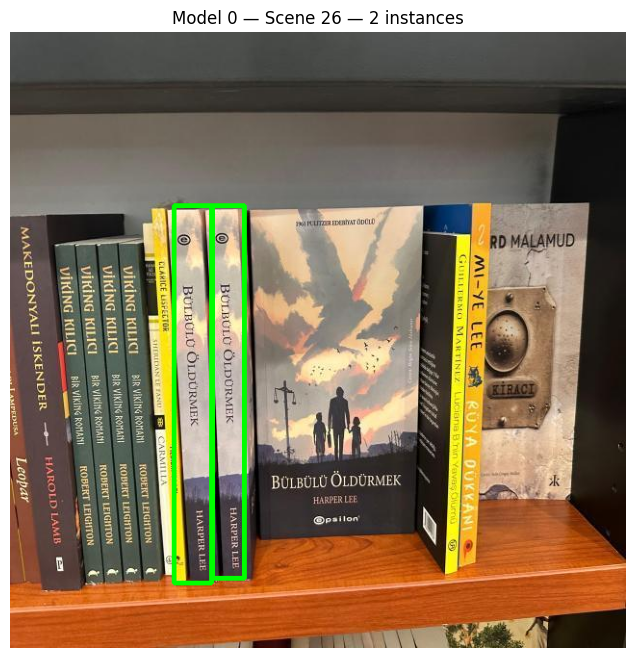

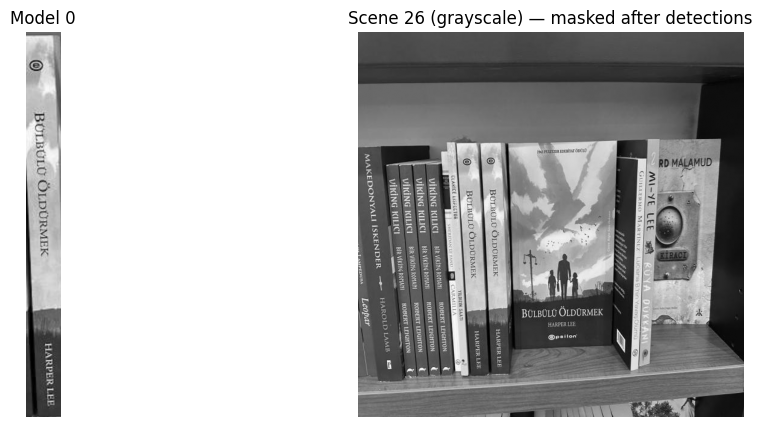

In [ ]:
# Choose indices to test (change these to try other pairs)
model_idx = 0
scene_idx = 26
max_instances = 10
# Prepare processed model
try:
    mdl = models_kp_des[model_idx]
    processed = {'image': mdl['img'], 'keypoints': mdl['kp'], 'descriptors': mdl['des']}
    sc = scenes_kp_des[scene_idx]
    img_scene_color = sc['img_color']
    img_scene_gray = sc['img_gray']
    print('Using precomputed data from notebook variables')
except Exception as e:
    print('Falling back to loading from disk:', e)
    model_paths = [f"dataset/models/model_{i}.png" for i in range(22)]
    scene_paths = [f"dataset/scenes/scene_{i}.jpg" for i in range(29)]
    img_model = cv2.imread(model_paths[model_idx], cv2.IMREAD_GRAYSCALE)
    img_scene_color = cv2.imread(scene_paths[scene_idx])
    img_scene_gray = cv2.cvtColor(img_scene_color, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp_m, des_m = sift.detectAndCompute(img_model, None)
    processed = {'image': img_model, 'keypoints': kp_m, 'descriptors': des_m}

# Run multi-instance detection
instances = detect_multiple_instances(processed, img_scene_color, img_scene_gray, max_instances=max_instances)
print(f'Model {model_idx} in Scene {scene_idx}: found {len(instances)} instance(s)')

# Print and visualize results
img_draw = img_scene_color.copy()
for k, inst in enumerate(instances, start=1):
    x_min, y_min, x_max, y_max = inst['bbox']
    area = inst['area']
    corners = inst['corners']
    print(f'  Instance {k} -> top_left=({x_min},{y_min}), top_right=({x_max},{y_min}), bottom_left=({x_min},{y_max}), bottom_right=({x_max},{y_max}), area={area}px')
    cv2.rectangle(img_draw, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB))
plt.title(f'Model {model_idx} — Scene {scene_idx} — {len(instances)} instances')
plt.axis('off')
plt.show()

# Optional: show the model and the grayscale scene for reference
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(processed['image'], cmap='gray')
plt.title(f'Model {model_idx}')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_scene_gray, cmap='gray')
plt.title(f'Scene {scene_idx} (grayscale) — masked after detections')
plt.axis('off')
plt.show()